R 4.4.1
输入：barcode_annotation.txt（标注的meta data），flow cytometry data（流式细胞仪数据）
功能：将各个统计数据和meta data整合到一起
输出：生成一个完整的meta data

### 1.Preparation

In [ ]:

library(curl)
library(httr)
library(plotly)
library(igraph)
library(ggplot2)
library(dplyr)
library(data.table)
# Set the number of threads in the data.table package to 64
setDTthreads(threads = 64)
library(ggpointdensity)
library(patchwork)
library(scales)
library(reshape2)
library(cowplot)
library(ggsci)
options(scipen = 999) #  Set the penalty value of scientific notation to avoid outputting results in scientific notation

### 2.Input

In [27]:
# meta data
meta <-data.table::fread("/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/barcode_annotation.txt", quote = F, sep = "\t", header=T )[, 1:20]  # First 20 columns

In [28]:
# flow cytometry data
IndexTmp_dir <- "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort"
list.files(IndexTmp_dir)

[1] "11280666_Nalm6_mono_sort_img.xlsx"   "11280669_Mart1_1 hour_sort_img.xlsx"
 [3] "11280671_Mart1_mono_sort_img.xlsx"   "11280672_TdT_1 hour_sort_img.xlsx"  
 [5] "11280827_Mart1_30min_sort_img.xlsx"  "11281062_TdT_mono_sort_img.xlsx"    
 [7] "11281186_Mart1_4hrs_sort_img.xlsx"   "11281187_TdT_4hrs_sort_img.xlsx"    
 [9] "11281346_TdT_1hour_sort2_img.xlsx"   "11281347_TdT_2hrs_sort_img.xlsx"    
[11] "11281348_Mart1_2hrs_sort_img.xlsx"   "11281349_Mart1_1hour_sort2_img.xlsx"
[13] "11281350_TdT_30min_sort_img.xlsx"

### 3.Meta data process

#### 3.1 Load barcode annotation

In [29]:

# Split the "condition" column into two columns, "time" and "cell" based on "_".
meta[, time := tstrsplit(meta$condition, "_", keep = 2) ][, cells := tstrsplit(meta$condition, "_", keep = 1)]  # 

In [30]:
head(meta)

BCset,XC_DNBPE,WellID,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Preamp_PCR,Index_PCR,TDE1,species,plate_ID,condition,empty_wells,comments,time,cells
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1A,GATAGGCACTGGAGTCATAC,A1,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTCAATGGAACG,A2,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTTTACGACGGT,A3,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTGTACTACCTC,A4,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTAGTACCAAGC,A5,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTTTGTCCTTGG,A6,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT


#### 3.2 Load flow cytometry data and merge into full meta data

In [31]:


# Get the full path of all .xlsx FC_files in a directory
FC_files <- list.files(path = IndexTmp_dir, full.names = TRUE, recursive = TRUE, pattern = '.xlsx')
head(FC_files)
# Delete the path and keep only the file name
filenames <- gsub(pattern = paste0(IndexTmp_dir,"/"), replacement = "", x = FC_files)
head(filenames)

[1] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11280666_Nalm6_mono_sort_img.xlsx"  
[2] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11280669_Mart1_1 hour_sort_img.xlsx"
[3] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11280671_Mart1_mono_sort_img.xlsx"  
[4] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11280672_TdT_1 hour_sort_img.xlsx"  
[5] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11280827_Mart1_30min_sort_img.xlsx" 
[6] "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/meta_data/index_sort/11281062_TdT_mono_sort_img.xlsx"

[1] "11280666_Nalm6_mono_sort_img.xlsx"   "11280669_Mart1_1 hour_sort_img.xlsx"
[3] "11280671_Mart1_mono_sort_img.xlsx"   "11280672_TdT_1 hour_sort_img.xlsx"  
[5] "11280827_Mart1_30min_sort_img.xlsx"  "11281062_TdT_mono_sort_img.xlsx"

In [32]:

# A list storing the results of processing each file in "FC_files"
merge_index_sort <- lapply(FC_files, function(x) {
  # Example: tmpfile = "/mnt/data/user/zhouhui/Nalm6_Tcell/pilot_experiment_082024/index_sort/11280666_Nalm6_mono_sort_img.xlsx"
  tmpfile = x
  
  # 1） Read file 
  tmp <- readxl::read_excel(tmpfile,, sheet = 1, col_names = FALSE)[-c(1:13),]  # Skip the first 13 lines(FC parameters)
  colnames(tmp) <- tmp[1,]
  tmp <- tmp[-1,]
  
  tmp <- tmp[, c("Well","Event","Sort Population","ImagePath","EventIndex","Time","FSC-A","SSC (Violet)-A","CD3 BB515-A","CD8a APC-Cy7-A","CD19 Pe-Cy7*-A","DAPI BV421-A","mTCRb PE-B*-A",
                 "Size (LightLoss (Imaging))","Size (FSC)","Size (SSC (Imaging))","Sorted","Row","Column","ImageID","Viability")]

  #Correct wellIDs to match barcode file
  # Note
    # (?<![0-9]) is a negative lookbehind assertion, it ensures that the content to be matched, which is 0, cannot be preceded by other numbers
    # 0* is used to match one or more 0
    # (?=[0-9]) is a positive lookahead assertion, it ensures that only zeros that are followed by other numbers are removed; single "0"s are not affected
    # Exaple
      # Before correct: "01", "001", "A01", "A001", "B010", "C02", "1001"
      # After correct:  "1"    "1"    "A1"   "A1"   "B10"  "C2"   "1001"
    # Use Perl-style regular expressions
  tmp$Well<-  gsub('(?<![0-9])0*(?=[0-9])', '', x = tmp$Well, perl=TRUE)
  
  #Add plate and BCSet info
  setDT(tmp) # Convert tmp to a data.table object
  # Extract the plate ID(e.g. 11280666 in 11280666_Nalm6_mono_sort_img.xlsx)
  tmp <- tmp[, plate:= tstrsplit(gsub(x = tstrsplit(tmpfile, "/")[[9]], pattern = ".xlsx", replacement = ""), "_",keep = 1)] 
  tmp[, BCset_indexsort := meta[meta$plate_ID ==  unique(tmp$plate)]$BCset ]

  #Add well specific barcodes.
  bcs_tmp <- meta[tmp$BCset_indexsort == meta$BCset]
  tmp2 <- merge(bcs_tmp, tmp, by.x = "WellID", by.y = "Well")
  return(tmp2)

})


New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...21`
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`
• `` -> `...26`
• `` -> `...27`
• `` -> `...28`
• `` -> `...29`
• `` -> `...30`
• `` -> `...31`
• `` -> `...32`
• `` -> `...33`
• `` -> `...34`
• `` -> `...35`
• `` -> `...36`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...40`
• `` -> `...41`
• `` -> `...42`
• `` -> `...43`
• `` -> `...44`
• `` -> `...45`
• `` -> `...46`
• `` -> `...47`
• `` -> `...48`
• `` -> `...49`
• `` -> `...50`
• `` -> `...51`
• `` -> `...52`
• `` -> `...53`
• `` -> `...54`
• `` -> `...55`
• `` -> `...56`
• `` -> `...57`
• `` -> `...58`
• `` -> `...59`
• `` -> `...60`
• `` -> `...61`
• `` -> `...62`
• `` -

In [33]:
# show the first 3 rows of first file in merge_index_sort
head(merge_index_sort[[1]], 3)

WellID,BCset,XC_DNBPE,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Size (LightLoss (Imaging)),Size (FSC),Size (SSC (Imaging)),Sorted,Row,Column,ImageID,Viability,plate,BCset_indexsort
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1,7F,TGCTAACGCAGTGACCGTTA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,925,1271,787,1,1,1,Nalm6,Live,11280666,7F
A10,7F,TGCTAACGCAGTTCGCTGAT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,828,1177,652,1,1,10,Nalm6,Live,11280666,7F
A11,7F,TGCTAACGCAATTGGACCTC,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,0,0,0,0,0,0,-,-,11280666,7F


In [34]:
# Modify the column name of merge_index_sort
print("Original column name:")
print(names(merge_index_sort))
names(merge_index_sort) <- gsub(filenames,pattern = ".xlsx", replacement = "")
print("New column name:")
print(names(merge_index_sort))

[1] "Original column name:"
NULL
[1] "New column name:"
 [1] "11280666_Nalm6_mono_sort_img"   "11280669_Mart1_1 hour_sort_img"
 [3] "11280671_Mart1_mono_sort_img"   "11280672_TdT_1 hour_sort_img"  
 [5] "11280827_Mart1_30min_sort_img"  "11281062_TdT_mono_sort_img"    
 [7] "11281186_Mart1_4hrs_sort_img"   "11281187_TdT_4hrs_sort_img"    
 [9] "11281346_TdT_1hour_sort2_img"   "11281347_TdT_2hrs_sort_img"    
[11] "11281348_Mart1_2hrs_sort_img"   "11281349_Mart1_1hour_sort2_img"
[13] "11281350_TdT_30min_sort_img"   


In [35]:
# Merge by rows
merge_index_sort_wide <- data.table::rbindlist(merge_index_sort)
merge_index_sort_wide <- merge_index_sort_wide[Event == 1]

In [36]:
head(merge_index_sort_wide,3)

WellID,BCset,XC_DNBPE,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Size (LightLoss (Imaging)),Size (FSC),Size (SSC (Imaging)),Sorted,Row,Column,ImageID,Viability,plate,BCset_indexsort
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1,7F,TGCTAACGCAGTGACCGTTA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,925,1271,787,1,1,1,Nalm6,Live,11280666,7F
A10,7F,TGCTAACGCAGTTCGCTGAT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,828,1177,652,1,1,10,Nalm6,Live,11280666,7F
A12,7F,TGCTAACGCATCGGATACGT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,936,1152,776,1,1,12,Nalm6,Live,11280666,7F


#### 3.3 Plotting

In [37]:
str(meta)
head(meta,3)

Classes ‘data.table’ and 'data.frame':	4992 obs. of  22 variables:
 $ BCset                : chr  "1A" "1A" "1A" "1A" ...
 $ XC_DNBPE             : chr  "GATAGGCACTGGAGTCATAC" "GATAGGCACTCAATGGAACG" "GATAGGCACTTTACGACGGT" "GATAGGCACTGTACTACCTC" ...
 $ WellID               : chr  "A1" "A2" "A3" "A4" ...
 $ sample_ID_Plate      : chr  "PW_11281062_retag" "PW_11281062_retag" "PW_11281062_retag" "PW_11281062_retag" ...
 $ conncentration       : num  16.3 16.3 16.3 16.3 16.3 16.3 16.3 16.3 16.3 16.3 ...
 $ average_size         : int  1030 1030 1030 1030 1030 1030 1030 1030 1030 1030 ...
 $ molarity             : num  24 24 24 24 24 ...
 $ desired molarity (nM): int  20 20 20 20 20 20 20 20 20 20 ...
 $ desired volume (uL)  : int  7 7 7 7 7 7 7 7 7 7 ...
 $ sample volume (uL)   : num  5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 ...
 $ water volume (uL)    : num  1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 ...
 $ run                  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Preamp_PCR           : 

BCset,XC_DNBPE,WellID,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Preamp_PCR,Index_PCR,TDE1,species,plate_ID,condition,empty_wells,comments,time,cells
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1A,GATAGGCACTGGAGTCATAC,A1,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTCAATGGAACG,A2,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT
1A,GATAGGCACTTTACGACGGT,A3,PW_11281062_retag,16.3,1030,23.98,20,7,5.8,⋯,15xPCR,14xPCR,0.007uL,human,11281062,TdT_mono,"A10, P10",OK,mono,TdT


In [38]:
str(merge_index_sort_wide)
head(merge_index_sort_wide)

Classes ‘data.table’ and 'data.frame':	4943 obs. of  44 variables:
 $ WellID                    : chr  "A1" "A10" "A12" "A13" ...
 $ BCset                     : chr  "7F" "7F" "7F" "7F" ...
 $ XC_DNBPE                  : chr  "TGCTAACGCAGTGACCGTTA" "TGCTAACGCAGTTCGCTGAT" "TGCTAACGCATCGGATACGT" "TGCTAACGCACCTACGATGT" ...
 $ sample_ID_Plate           : chr  "PW_11280666_retag" "PW_11280666_retag" "PW_11280666_retag" "PW_11280666_retag" ...
 $ conncentration            : num  17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 ...
 $ average_size              : int  1324 1324 1324 1324 1324 1324 1324 1324 1324 1324 ...
 $ molarity                  : num  20.3 20.3 20.3 20.3 20.3 ...
 $ desired molarity (nM)     : int  20 20 20 20 20 20 20 20 20 20 ...
 $ desired volume (uL)       : int  7 7 7 7 7 7 7 7 7 7 ...
 $ sample volume (uL)        : num  6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 ...
 $ water volume (uL)         : num  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 $ run                 

WellID,BCset,XC_DNBPE,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Size (LightLoss (Imaging)),Size (FSC),Size (SSC (Imaging)),Sorted,Row,Column,ImageID,Viability,plate,BCset_indexsort
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1,7F,TGCTAACGCAGTGACCGTTA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,925,1271,787,1,1,1,Nalm6,Live,11280666,7F
A10,7F,TGCTAACGCAGTTCGCTGAT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,828,1177,652,1,1,10,Nalm6,Live,11280666,7F
A12,7F,TGCTAACGCATCGGATACGT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,936,1152,776,1,1,12,Nalm6,Live,11280666,7F
A13,7F,TGCTAACGCACCTACGATGT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,1032,1247,863,1,1,13,Nalm6,Live,11280666,7F
A14,7F,TGCTAACGCATGATTCCACG,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,1010,1177,824,1,1,14,Exclude,Live,11280666,7F
A15,7F,TGCTAACGCACTAAGGACGA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,851,1115,718,1,1,15,Nalm6,Live,11280666,7F


In [39]:

meta_full <- merge_index_sort_wide


In [40]:
meta_cleaned <- meta_full[,c(1:19,32:37)]
str(meta_cleaned)

Classes ‘data.table’ and 'data.frame':	4943 obs. of  25 variables:
 $ WellID                    : chr  "A1" "A10" "A12" "A13" ...
 $ BCset                     : chr  "7F" "7F" "7F" "7F" ...
 $ XC_DNBPE                  : chr  "TGCTAACGCAGTGACCGTTA" "TGCTAACGCAGTTCGCTGAT" "TGCTAACGCATCGGATACGT" "TGCTAACGCACCTACGATGT" ...
 $ sample_ID_Plate           : chr  "PW_11280666_retag" "PW_11280666_retag" "PW_11280666_retag" "PW_11280666_retag" ...
 $ conncentration            : num  17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 17.7 ...
 $ average_size              : int  1324 1324 1324 1324 1324 1324 1324 1324 1324 1324 ...
 $ molarity                  : num  20.3 20.3 20.3 20.3 20.3 ...
 $ desired molarity (nM)     : int  20 20 20 20 20 20 20 20 20 20 ...
 $ desired volume (uL)       : int  7 7 7 7 7 7 7 7 7 7 ...
 $ sample volume (uL)        : num  6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 6.9 ...
 $ water volume (uL)         : num  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
 $ run                 

In [41]:

p1 = ggplot(meta_full, aes(x = as.numeric(`FSC-A`), y = as.numeric(`SSC (Violet)-A`))) + 
  ggpointdensity::geom_pointdensity() +
  theme_bw() +
  scale_color_viridis_c(option = 'magma', guide = "none") + 
  xlab("FSC") + ylab("SSC") + 
  ggtitle("FSC vs SSC Density Plot")  


p2 = ggplot(meta_full, aes(x = as.numeric(`CD3 BB515-A`), y = as.numeric(`CD8a APC-Cy7-A`))) + 
  ggpointdensity::geom_pointdensity() +
  theme_bw() +
  scale_color_viridis_c(option = 'magma', guide = "none") + 
  scale_x_log10(limits = c(5, 1000000)) +
  scale_y_log10(limits = c(10, 1000000)) +
  annotation_logticks(sides = 'bl') + 
  xlab("CD3") + ylab("CD8a") + 
  geom_hline(yintercept = 1000, linetype = 'dashed', color = 'firebrick') + 
  geom_vline(xintercept = 1000, linetype = 'dashed', color = 'firebrick') +
  ggtitle("CD3 vs. CD8a Density Plot")  


p3 = ggplot(meta_full, aes(x = as.numeric(`CD3 BB515-A`), y = as.numeric(`CD19 Pe-Cy7*-A`))) + 
  ggpointdensity::geom_pointdensity() +
  theme_bw() +
  scale_color_viridis_c(option = 'magma', guide = "none") +  
  scale_x_log10(limits = c(5, 1000000)) +
  scale_y_log10(limits = c(10, 1000000)) +
  annotation_logticks(sides = 'bl') + 
  xlab("CD3") + ylab("CD19") + 
  geom_hline(yintercept = 2000, linetype = 'dashed', color = 'firebrick') + 
  geom_vline(xintercept = 10000, linetype = 'dashed', color = 'firebrick') +
  ggtitle("CD3 vs CD19 MFI Density Plot") 

p4 = ggplot(meta_full, aes(x = as.numeric(`DAPI BV421-A`), y = as.numeric(`CD8a APC-Cy7-A`))) + 
  ggpointdensity::geom_pointdensity() +
  theme_bw() +
  scale_color_viridis_c(option = 'magma', guide = "none") +  
  scale_x_log10(limits = c(5, 1000000)) +
  scale_y_log10(limits = c(10, 1000000)) +
  annotation_logticks(sides = 'bl') + 
  xlab("DAPI") + ylab("CD8a") + 
  geom_hline(yintercept = 2000, linetype = 'dashed', color = 'firebrick') + 
  geom_vline(xintercept = 10000, linetype = 'dashed', color = 'firebrick') +
  facet_wrap(~sample_ID_Plate) +
  ggtitle("DAPI vs CD8a MFI Density Plot by Sample")  

Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10(limits = c(5, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10(limits = c(10, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1383 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”


Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10(limits = c(5, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10(limits = c(10, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 364 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10(limits = c(5, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10(limits = c(10, 1000000)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2248 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”


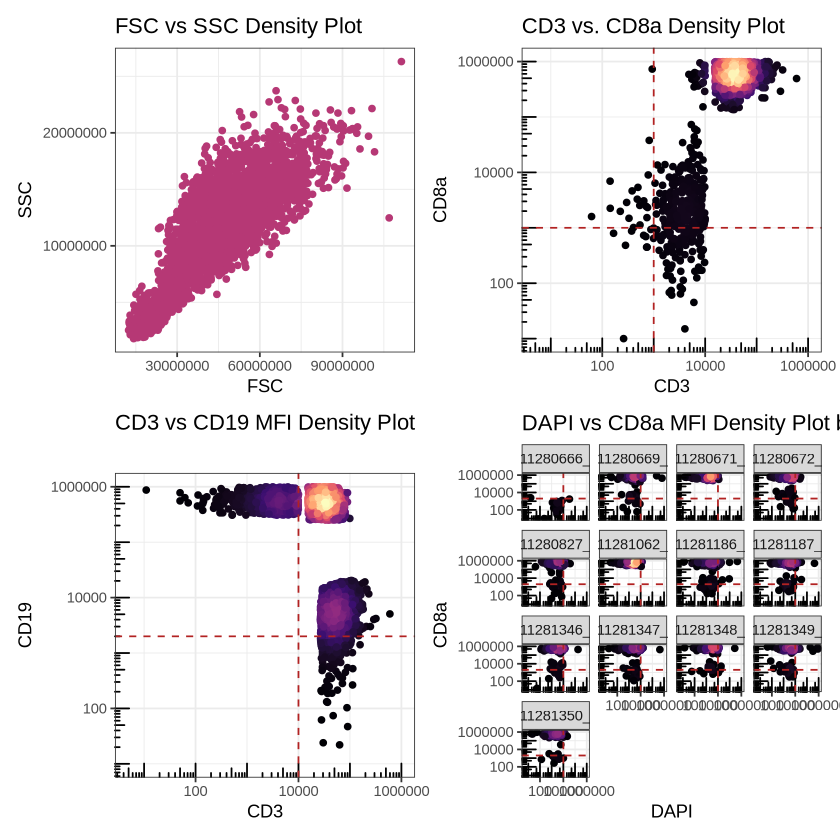

In [42]:
fc_plot <- p1 + p2 + p3 + p4
fc_plot

In [43]:
#ggsave(p1, filename = "/mnt/nvme/home/zhouhui/project_workspace/Tcell_NALM6_project/Seurat_analysis/reorganized_version/basic_analysis_plot/fc_plot/FSC_SSC_Density_Plot.png", height = 8, width = 8)
#ggsave(p2, filename = "/mnt/nvme/home/zhouhui/project_workspace/Tcell_NALM6_project/Seurat_analysis/reorganized_version/basic_analysis_plot/fc_plot/CD3_CD8a_Density_Plot.png", height = 8, width = 8)
#ggsave(p3, filename = "/mnt/nvme/home/zhouhui/project_workspace/Tcell_NALM6_project/Seurat_analysis/reorganized_version/basic_analysis_plot/fc_plot/CD3_CD19_Density Plot.png", height = 8, width = 8)


### 4.Output

In [44]:
head(meta_full)
colnames(meta_full)

WellID,BCset,XC_DNBPE,sample_ID_Plate,conncentration,average_size,molarity,desired molarity (nM),desired volume (uL),sample volume (uL),⋯,Size (LightLoss (Imaging)),Size (FSC),Size (SSC (Imaging)),Sorted,Row,Column,ImageID,Viability,plate,BCset_indexsort
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1,7F,TGCTAACGCAGTGACCGTTA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,925,1271,787,1,1,1,Nalm6,Live,11280666,7F
A10,7F,TGCTAACGCAGTTCGCTGAT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,828,1177,652,1,1,10,Nalm6,Live,11280666,7F
A12,7F,TGCTAACGCATCGGATACGT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,936,1152,776,1,1,12,Nalm6,Live,11280666,7F
A13,7F,TGCTAACGCACCTACGATGT,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,1032,1247,863,1,1,13,Nalm6,Live,11280666,7F
A14,7F,TGCTAACGCATGATTCCACG,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,1010,1177,824,1,1,14,Exclude,Live,11280666,7F
A15,7F,TGCTAACGCACTAAGGACGA,PW_11280666_retag,17.7,1324,20.26,20,7,6.9,⋯,851,1115,718,1,1,15,Nalm6,Live,11280666,7F


[1] "WellID"                     "BCset"                     
 [3] "XC_DNBPE"                   "sample_ID_Plate"           
 [5] "conncentration"             "average_size"              
 [7] "molarity"                   "desired molarity (nM)"     
 [9] "desired volume (uL)"        "sample volume (uL)"        
[11] "water volume (uL)"          "run"                       
[13] "Preamp_PCR"                 "Index_PCR"                 
[15] "TDE1"                       "species"                   
[17] "plate_ID"                   "condition"                 
[19] "empty_wells"                "comments"                  
[21] "time"                       "cells"                     
[23] "Event"                      "Sort Population"           
[25] "ImagePath"                  "EventIndex"                
[27] "Time"                       "FSC-A"                     
[29] "SSC (Violet)-A"             "CD3 BB515-A"               
[31] "CD8a APC-Cy7-A"             "CD19 Pe-Cy7*-A"            
[33] "DAPI BV421-A"               "mTCRb PE-B*-A"             
[35] "Size (LightLoss (Imaging))" "Size (FSC)"                
[37] "Size (SSC (Imaging))"       "Sorted"                    
[39] "Row"                        "Column"                    
[41] "ImageID"                    "Viability"                 
[43] "plate"                      "BCset_indexsort"

In [45]:
colnames(meta_full) <- gsub("Sort Population", "Sort_Population", colnames(meta_full))

In [46]:
write.table(meta_full, file = "/mnt/data/user/zhouhui/T_cells_dymamics_data_results/results/stats_all_0.txt", sep = "\t", quote = F,row.names = F)